In [1]:
from datamodel import Listing, Order, OrderDepth, Trade, TradingState
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os, sys

#Class for hiding print statements from trader class
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
#Order limits set by the competition
order_limits = { 'PEARLS':20, 
                 'BANANAS':20, 
                 'COCONUTS':600, 
                 'PINA_COLADAS':300, 
                 'BERRIES':250, 
                 'DIVING_GEAR':50,                  
                 'BAGUETTE': 150,
                 'DIP': 300,
                 'UKULELE': 70,
                 'PICNIC_BASKET': 70,
                }


def backtest( df_back, df_trades, trader, suppress_print=True, observe_order_limits=True ):
    """
    Backtesting function. Returns dictionary of total pnls.
    """

    tsmin = df_back['timestamp'].min()
    tsmax = df_back['timestamp'].max()
    timestamps = range( tsmin, tsmax+100, 100 )

    obs_keys = [ 'DOLPHIN_SIGHTINGS' ]        
    products = list(df_back['product'].unique())

    num_prods = len(products)

    portfolio = { pr:0 for pr in products }
    cash = { pr:0 for pr in products } #cashflow for each product
    pnl = { pr:0 for pr in products } #PNL, total value of portfolio + cash
    
    total_pnls = { pr:[] for pr in products } 
    total_cash = { pr:[] for pr in products } 
    total_pos = { pr:[] for pr in products }

    out_df = pd.DataFrame()
    
    for ts in timestamps:

    #     df_ts = df_back[ df_back['timestamp']==ts ]
        df_ts = df_back[(ts//100)*num_prods:(ts//100+1)*num_prods]

        order_depths = {}

        for prod in df_ts['product']:
            df_prod = df_ts[ df_ts['product']==prod ]
            order_depths[prod] = OrderDepth()
            order_depths[prod].buy_orders = {}
            order_depths[prod].sell_orders = {}

            for i in range(1,4):
                bpr = df_prod[f'bid_price_{i}'].values[0]
                bqu = df_prod[f'bid_volume_{i}'].values[0]
                spr = df_prod[f'ask_price_{i}'].values[0]
                squ = df_prod[f'ask_volume_{i}'].values[0]
                if not np.isnan(bpr):
                    order_depths[prod].buy_orders[bpr] = bqu
                if not np.isnan(spr):
                    order_depths[prod].sell_orders[spr] = -squ

        observations = { obs:df_ts[ df_ts['product']==obs ]['mid_price'].values[0] for obs in obs_keys }

        market_trades = { pr:[] for pr in products }
        trades_ts = df_trades[ df_trades['timestamp'] == ts-100 ]
        for index, row in trades_ts.iterrows():
            market_trades[row.symbol].append(Trade( row.symbol, row.price, row.quantity, row.buyer, row.seller, row.timestamp))

        
        trading_state = TradingState(ts,
                                     {},
                                     order_depths,
                                     {},
                                     market_trades,
                                     portfolio,
                                     observations)

        if suppress_print:
            with HiddenPrints(): #Hide print statements from algo
                trade_result = trader.run( trading_state )
        else:
            trade_result = trader.run( trading_state )
                        
        for prod in trade_result:
            for order in trade_result[prod]:
                order_within_limit = True
                if observe_order_limits:
                    if abs(portfolio[order.symbol] + order.quantity) > order_limits[order.symbol]:
                        order_within_limit = False
                    
                if order_within_limit:
                    portfolio[order.symbol] = portfolio[order.symbol] + order.quantity 
                    cash[order.symbol] = cash[order.symbol] - order.quantity * order.price
                    
        for prod in products:
            prod_price = df_ts[ df_ts['product']==prod ]['mid_price'].values[0]
            pnl[prod] = portfolio[prod] * prod_price + cash[prod]
            total_pnls[prod].append(pnl[prod])
            
            total_cash[prod].append(cash[prod])
            total_pos[prod].append(portfolio[prod])            

        if ts%10000==0: 
            print(f"Simulating trading state for timestamp {ts}/{tsmax}", end='\r')
    #         print("Portfolio at end of turn:", portfolio)
    #         print("Cash at end of turn:", cash)
    #         print("PNL at end of turn:", pnl)

    
    out_df = pd.concat({ 'pnl': pd.DataFrame(total_pnls), 
                        'cashflow': pd.DataFrame(total_cash), 
                        'position': pd.DataFrame(total_pos) }, axis=1 )

    out_df['timestamp'] = np.arange( tsmin, tsmax+100, 100 )

#     return total_pnls
    return out_df
    
#  TradingState Argument list. Will probably have to update this in subsequent rounds
#  timestamp: Time,
#  listings: Dict[Symbol, Listing], (not used)
#  order_depths: Dict[Symbol, OrderDepth], 
#  own_trades: Dict[Symbol, List[Trade]], (not used)
#  market_trades: Dict[Symbol, List[Trade]], (not used)
#  position: Dict[Product, Position], (not used)
#  observations: Dict[Product, Observation]) (not used)

In [33]:
# import round03_program as my_program
# import round04_program as my_program
import round05_program as my_program

In [34]:
# df0 = pd.read_csv("island-data-bottle-round-3/prices_round_3_day_0.csv", delimiter=';')
# df1 = pd.read_csv("island-data-bottle-round-3/prices_round_3_day_1.csv", delimiter=';')
# df2 = pd.read_csv("island-data-bottle-round-3/prices_round_3_day_2.csv", delimiter=';')

# df00 = pd.read_csv("island-data-bottle-round-3/prices_round_3_day_0.csv", delimiter=';')
df0 = pd.read_csv("island-data-bottle-round-4/prices_round_4_day_1.csv", delimiter=';')
df1 = pd.read_csv("island-data-bottle-round-4/prices_round_4_day_2.csv", delimiter=';')
df2 = pd.read_csv("island-data-bottle-round-4/prices_round_4_day_3.csv", delimiter=';')
# df3 = pd.read_csv("round-4-results.csv", delimiter=';')

trdf0 = pd.read_csv("island-data-bottle-round-5/trades_round_4_day_1_wn.csv", delimiter=';')
trdf1 = pd.read_csv("island-data-bottle-round-5/trades_round_4_day_2_wn.csv", delimiter=';')
trdf2 = pd.read_csv("island-data-bottle-round-5/trades_round_4_day_3_wn.csv", delimiter=';')
# df3 = pd.read_csv("round-4-results.csv", delimiter=';')

In [63]:
# test_dfs = [ df0, df1, df2, df3 ]
test_dfs = [ 
            (df0, trdf0),
            (df1, trdf1),
            (df2, trdf2),
]

In [69]:
importlib.reload(my_program)

test_parameters = {
#      "order_limits": [ lims_1, lims_2 ]
    "do_trader_obs" : [True, False]
#     "mm_do_market_orders": [True, False]
}

pnl_dicts = {}
for param in test_parameters:
    for val in test_parameters[param]:
        kwargs = { param:val }
        print(f"Performing backtest with {param} = {val}")     
        
        pnls_test = []
        for idf, dfs in enumerate(test_dfs):
            print(f"Day {idf+1}/{len(test_dfs)}")
            trader = my_program.Trader( **kwargs )
#             df_pnls = backtest( dfs[0], dfs[1], trader, False, True )
            df_pnls = backtest( dfs[0], dfs[1], trader, True, True )
            pnls_test.append( df_pnls )        
            print('\n',end='')
                
#         total_pnls = pd.concat([pd.DataFrame(p) for p in pnls_test])
        total_pnls = pd.concat(pnls_test, axis=0)        
            
        pnl_dicts[f"{param}={val}"] = total_pnls 

Performing backtest with do_trader_obs = True
Day 1/3
Simulating trading state for timestamp 990000/999900
Day 2/3
Simulating trading state for timestamp 990000/999900
Day 3/3
Simulating trading state for timestamp 990000/999900
Performing backtest with do_trader_obs = False
Day 1/3
Simulating trading state for timestamp 990000/999900
Day 2/3
Simulating trading state for timestamp 990000/999900
Day 3/3
Simulating trading state for timestamp 990000/999900


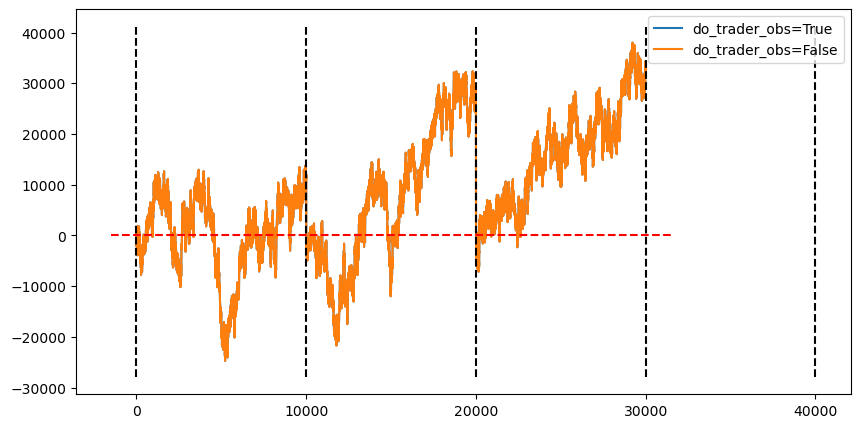

In [73]:
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pnl_dicts[key]['pnl']
    
#     test_pnl = df_pnls['PICNIC_BASKET'] + df_pnls['UKULELE'] + df_pnls['DIP'] + df_pnls['BAGUETTE']    
    test_pnl = df_pnls['PINA_COLADAS'] + df_pnls['COCONUTS']    
    
#     test_pnl = df_pnls['BERRIES']
#     test_pnl = df_pnls['BANANAS']    
#     test_pnl = df_pnls['PEARLS']    
    
    test_pnl = test_pnl.rolling(1).mean()
    plt.plot( test_pnl.values, label=key[:100] )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4,4e4], ymin, ymax, 'k', '--')
plt.plot( [xmin, xmax], [0,0], 'r--')

plt.legend()

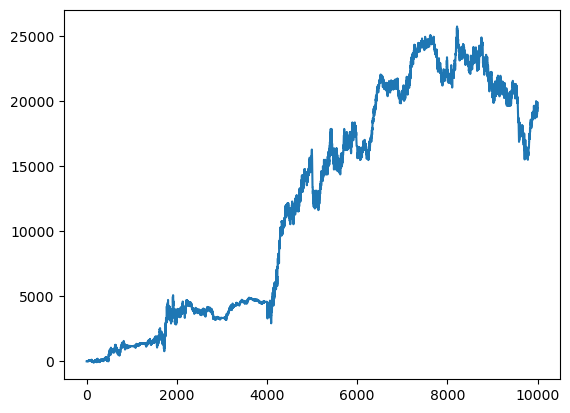

In [475]:
plt.plot( pnl_dicts[ list(pnl_dicts.keys())[0] ]['pnl']['BERRIES'] )

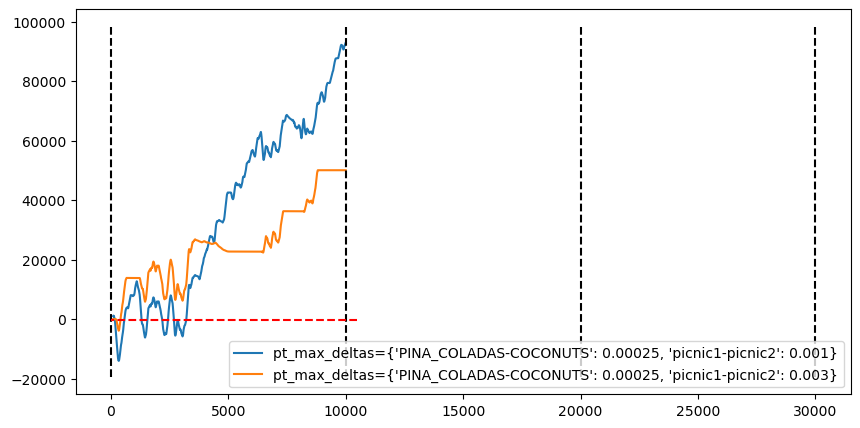

In [260]:
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])
    
    test_pnl = df_pnls['PICNIC_BASKET'] + df_pnls['UKULELE'] + df_pnls['DIP'] + df_pnls['BAGUETTE']    
#     test_pnl = df_pnls['PINA_COLADAS'] + df_pnls['COCONUTS']    
    
#     test_pnl = df_pnls['BERRIES']
    
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4], ymin, ymax, 'k', '--')
plt.hlines(xmin, xmax, [0], 'r', '--')

plt.legend()

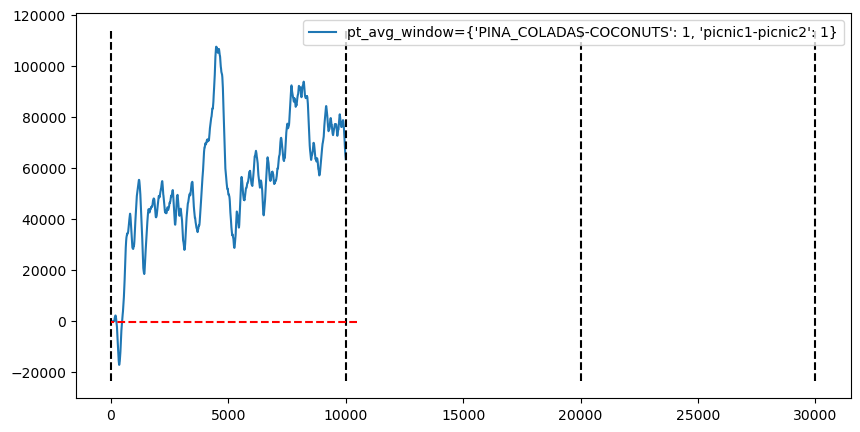

In [252]:
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])
    
    test_pnl = df_pnls['PICNIC_BASKET'] + df_pnls['UKULELE'] + df_pnls['DIP'] + df_pnls['BAGUETTE']    
#     test_pnl = df_pnls['PINA_COLADAS'] + df_pnls['COCONUTS']    
    
#     test_pnl = df_pnls['BERRIES']
    
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4], ymin, ymax, 'k', '--')
plt.hlines(xmin, xmax, [0], 'r', '--')

plt.legend()

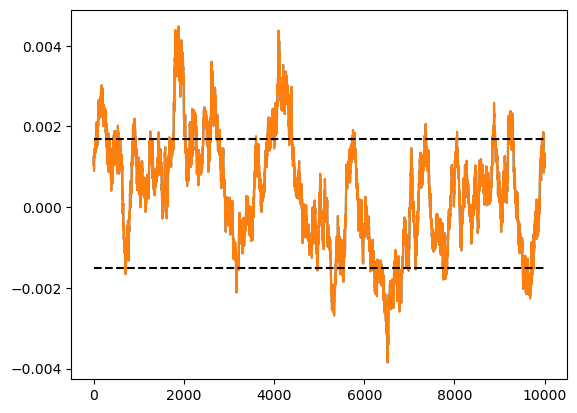

In [238]:
dfi = df1

dp = dfi[ dfi['product'] == 'PICNIC_BASKET' ]['mid_price'].values
db = dfi[ dfi['product'] == 'BAGUETTE' ]['mid_price'].values
dd = dfi[ dfi['product'] == 'DIP' ]['mid_price'].values
du = dfi[ dfi['product'] == 'UKULELE' ]['mid_price'].values

# plt.plot( dp / 74025 )
# plt.plot( (du + 2 * db + 4 * dd) / 73650 )

plt.plot( (dp / 74025 - ( (du + 2 * db + 4 * dd) / 73650) ) )
plt.plot( (dp / 74025 - ( (du + 2 * db + 4 * dd) / 73650) ) ) 

plt.plot( [0,1e4],[0.0017,0.0017], 'k--' )
plt.plot( [0,1e4],[-0.0015,-0.0015], 'k--' )


# df_pnls['UKULELE'] + df_pnls['DIP'] * 4 + df_pnls['BAGUETTE'] * 2 

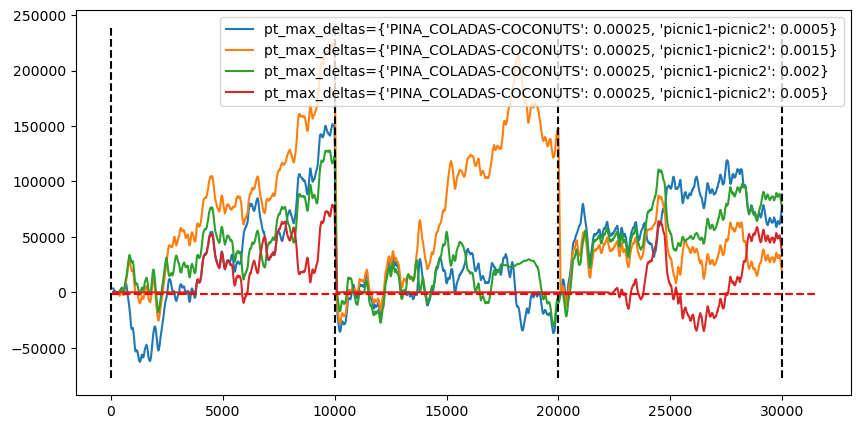

In [187]:
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])
    
    test_pnl = df_pnls['PICNIC_BASKET'] + df_pnls['UKULELE'] + df_pnls['DIP'] * 4 + df_pnls['BAGUETTE'] * 2    
#     test_pnl = df_pnls['PINA_COLADAS'] + df_pnls['COCONUTS']    
    
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4], ymin, ymax, 'k', '--')
plt.hlines(xmin, xmax, [0], 'r', '--')

plt.legend()

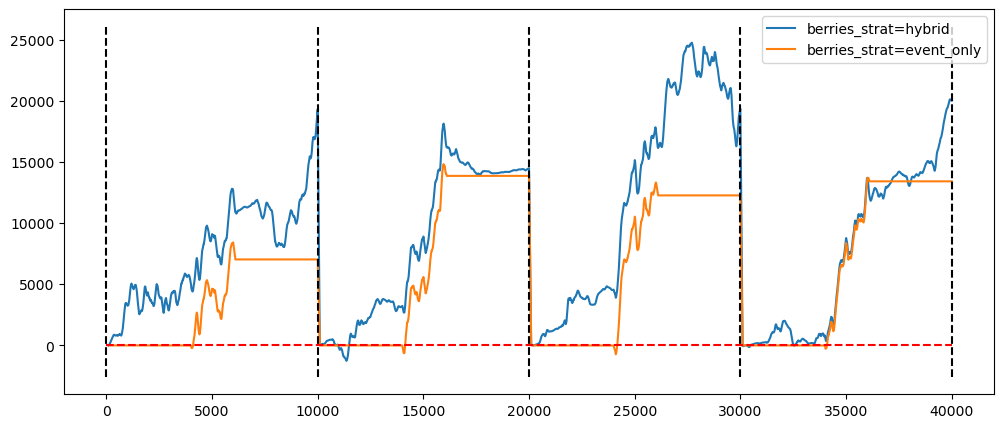

In [182]:
fig = plt.figure(figsize=(12,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])    
    test_pnl = df_pnls['BERRIES'] 
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4,4e4], ymin, ymax, 'k', '--')
plt.plot( [0,4e4],[0,0],'r--' )

plt.legend()

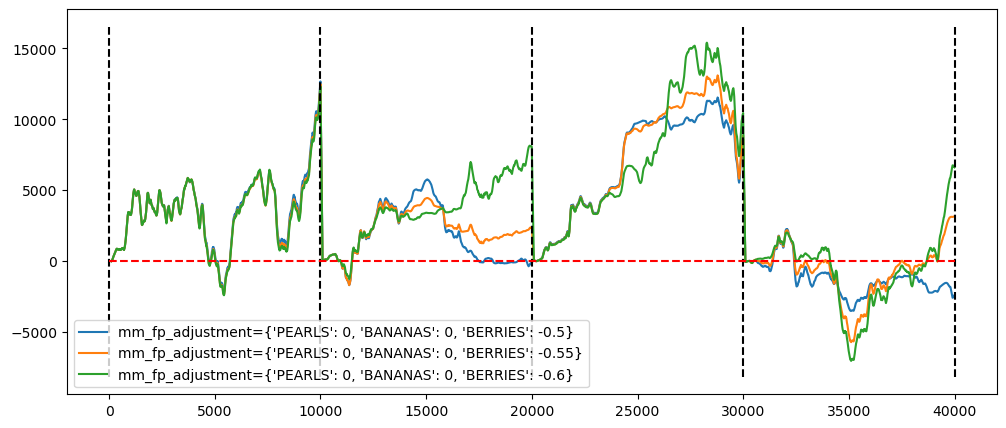

In [177]:
fig = plt.figure(figsize=(12,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])    
    test_pnl = df_pnls['BERRIES'] 
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4,4e4], ymin, ymax, 'k', '--')
plt.plot( [0,4e4],[0,0],'r--' )

plt.legend()

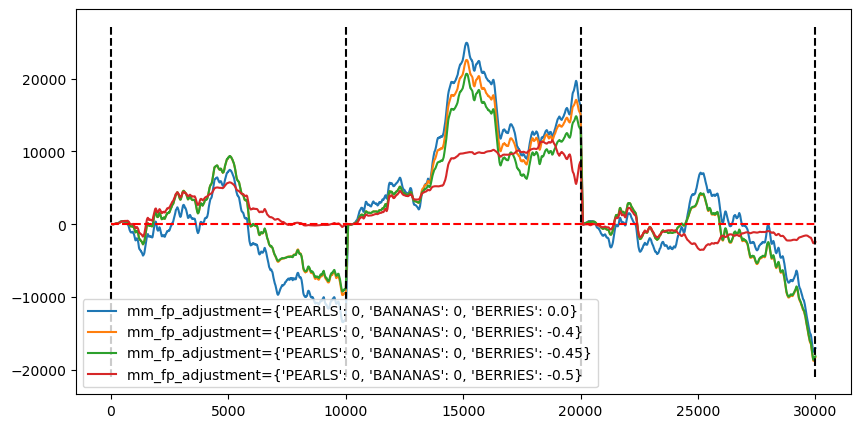

In [168]:
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])    
    test_pnl = df_pnls['BERRIES'] 
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4], ymin, ymax, 'k', '--')
plt.plot( [0,3e4],[0,0],'r--' )

plt.legend()

In [ ]:
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])    
    test_pnl = df_pnls['BERRIES'] 
    test_pnl = test_pnl.rolling(100).mean()
    plt.plot( test_pnl.values, label=key )

xmin,xmax,ymin,ymax = plt.axis()
plt.vlines([0,1e4,2e4,3e4], ymin, ymax, 'k', '--')
plt.hlines(xmin, xmax, [0], 'r', '--')

plt.legend()

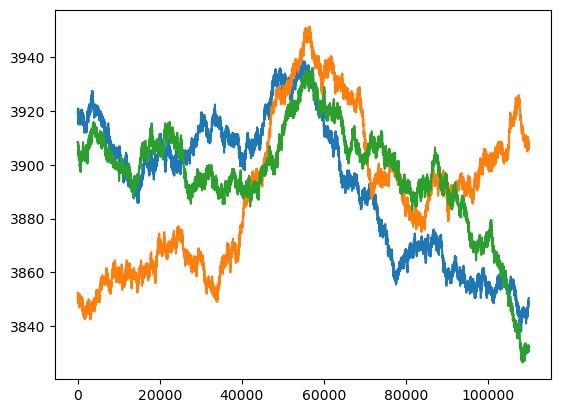

In [119]:
plt.plot( df0[df0['product'] == 'BERRIES']['mid_price'] )
plt.plot( df1[df1['product'] == 'BERRIES']['mid_price'] )
plt.plot( df2[df2['product'] == 'BERRIES']['mid_price'] )

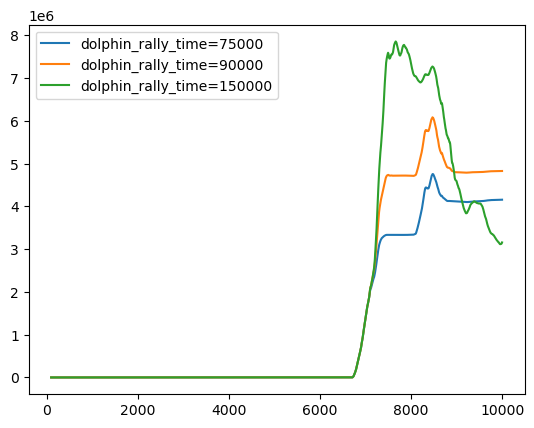

In [178]:
for idx, key in enumerate(pnl_dicts):
    df_pnls = pd.DataFrame(pnl_dicts[key])
    test_pnl = df_pnls['DIVING_GEAR'].rolling(100).mean()
    plt.plot( test_pnl, label=key )
    
# plt.ylim(-1e4,1.3e5)
plt.legend()

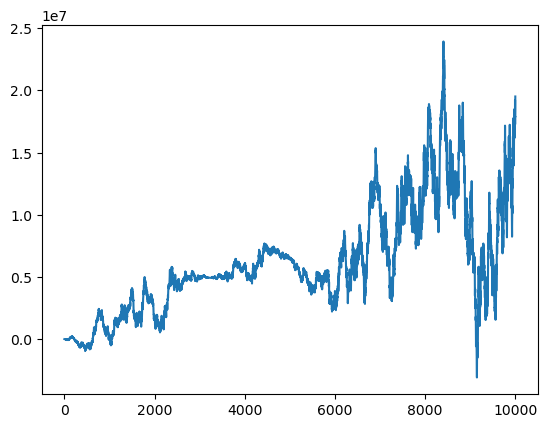

In [180]:
plt.plot( df_pnls['COCONUTS'].values + df_pnls['PINA_COLADAS'].values ) 

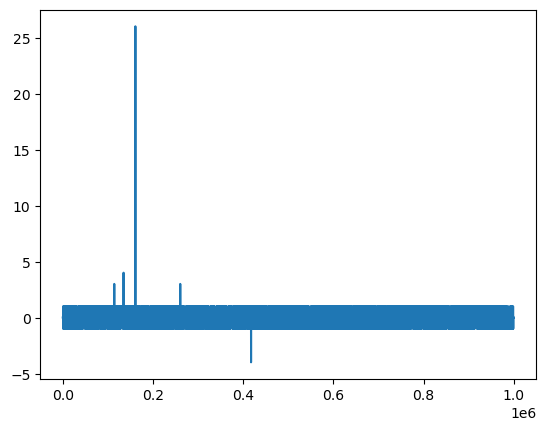

In [217]:
ds = df_history[df_history['product']=='DOLPHIN_SIGHTINGS']['mid_price'].values
ts = df_history[df_history['product']=='DOLPHIN_SIGHTINGS']['timestamp'].values

plt.plot( ts[:-1],ds[1:] - ds[:-1] )

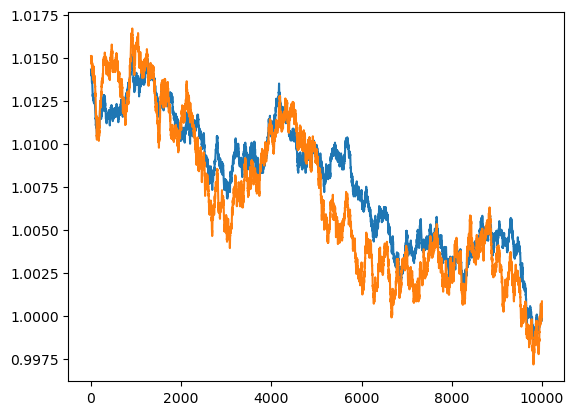

In [37]:
plt.plot( df_history[df_history['product']=='COCONUTS']['mid_price'].values/8000 )
plt.plot( df_history[df_history['product']=='PINA_COLADAS']['mid_price'].values/15000 )